In [136]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [137]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [138]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [139]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [140]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [141]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [142]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

175

In [143]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [144]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  hist_month_nunique  hist_hour_nunique  hist_weekofyear_nunique  \
0 -0.820283                   9                 23                       35   
1  0.392913                  12                 24                       50   
2  0.688056                  10                 14                       22   
3  0.142495                   6                 16                       20   
4 -0.159749                   4                 22                       17   

   hist_dayofweek_nunique               ...                \
0                       7               ...                 
1                       7               ...                 
2                       7               ...                 
3                       7               ...                 
4                       7               ...                 

   new_hist_weekend_sum  new_hist_weekend_mean  new_hist_category_1_sum  \
0                   6.0               0.260870                      0.0   
1                   0.0               0.000000                      0.0   
2                   1.0               1.000000                      0.0   
3                   3.0               0.428571                      1.0   
4                  12.0               0.333333                      2.0   

   new_hist_category_1_mean  new_hist_card_id_size  \
0                  0.000000                   23.0   
1                  0.000000                    6.0   
2                  0.000000                    1.0   
3                  0.142857                    7.0   
4                  0.055556                   36.0   

   new_hist_category_2_mean_mean  new_hist_category_3_mean_mean  \
0                  1.658319e+108                   1.381361e+36   
1                  1.658319e+108                   3.557623e+25   
2                   7.789907e+26                   1.381361e+36   
3                  2.369028e+107                   1.973373e+35   
4                  1.842577e+107                  3.624714e+107   

   new_hist_purchase_date_diff  new_hist_purchase_date_average  \
0                         54.0                        2.347826   
1                         56.0                        9.333333   
2                          0.0                        0.000000   
3                         41.0                        5.857143   
4                         57.0                        1.583333   

   new_hist_purchase_date_uptonow  
0                           230.0  
1                           260.0  
2                           231.0  
3                           241.0  
4                           231.0  

[5 rows x 78 columns]

In [145]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [146]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [147]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [148]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [149]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [150]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")

In [151]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [152]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = df_train['target']
target_outlier = df_train["outliers"]
del df_train['target']

In [159]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.80749	valid_1's rmse: 3.83194
[200]	training's rmse: 3.77186	valid_1's rmse: 3.80725
[300]	training's rmse: 3.74014	valid_1's rmse: 3.78616
[400]	training's rmse: 3.71166	valid_1's rmse: 3.76842
[500]	training's rmse: 3.686	valid_1's rmse: 3.75274
[600]	training's rmse: 3.66286	valid_1's rmse: 3.7396
[700]	training's rmse: 3.64167	valid_1's rmse: 3.72847
[800]	training's rmse: 3.62232	valid_1's rmse: 3.71893
[900]	training's rmse: 3.60433	valid_1's rmse: 3.71092
[1000]	training's rmse: 3.58737	valid_1's rmse: 3.70411
[1100]	training's rmse: 3.57089	valid_1's rmse: 3.698
[1200]	training's rmse: 3.55512	valid_1's rmse: 3.6929
[1300]	training's rmse: 3.54023	valid_1's rmse: 3.68868
[1400]	training's rmse: 3.52612	valid_1's rmse: 3.68522
[1500]	training's rmse: 3.51301	valid_1's rmse: 3.6821
[1600]	training's rmse: 3.50083	valid_1's rmse: 3.67904
[1700]	training's rmse: 3.48874	valid_1's rmse: 3.

[4600]	training's rmse: 3.25783	valid_1's rmse: 3.65636
[4700]	training's rmse: 3.25228	valid_1's rmse: 3.65622
[4800]	training's rmse: 3.24664	valid_1's rmse: 3.65599
[4900]	training's rmse: 3.24098	valid_1's rmse: 3.65593
[5000]	training's rmse: 3.23547	valid_1's rmse: 3.65582
[5100]	training's rmse: 3.23016	valid_1's rmse: 3.65577
[5200]	training's rmse: 3.22465	valid_1's rmse: 3.65564
[5300]	training's rmse: 3.21937	valid_1's rmse: 3.65561
[5400]	training's rmse: 3.21428	valid_1's rmse: 3.65552
[5500]	training's rmse: 3.20932	valid_1's rmse: 3.65544
[5600]	training's rmse: 3.20451	valid_1's rmse: 3.6554
[5700]	training's rmse: 3.19958	valid_1's rmse: 3.65541
[5800]	training's rmse: 3.21695	valid_1's rmse: 3.6744
[5900]	training's rmse: 3.20675	valid_1's rmse: 3.67044
[6000]	training's rmse: 3.19778	valid_1's rmse: 3.66725
[6100]	training's rmse: 5.44797	valid_1's rmse: 5.73922
Early stopping, best iteration is:
[5747]	training's rmse: 3.1973	valid_1's rmse: 3.65535
fold 4
Training 

3.6531501369212216

In [161]:
# score:  3.6458692529031196

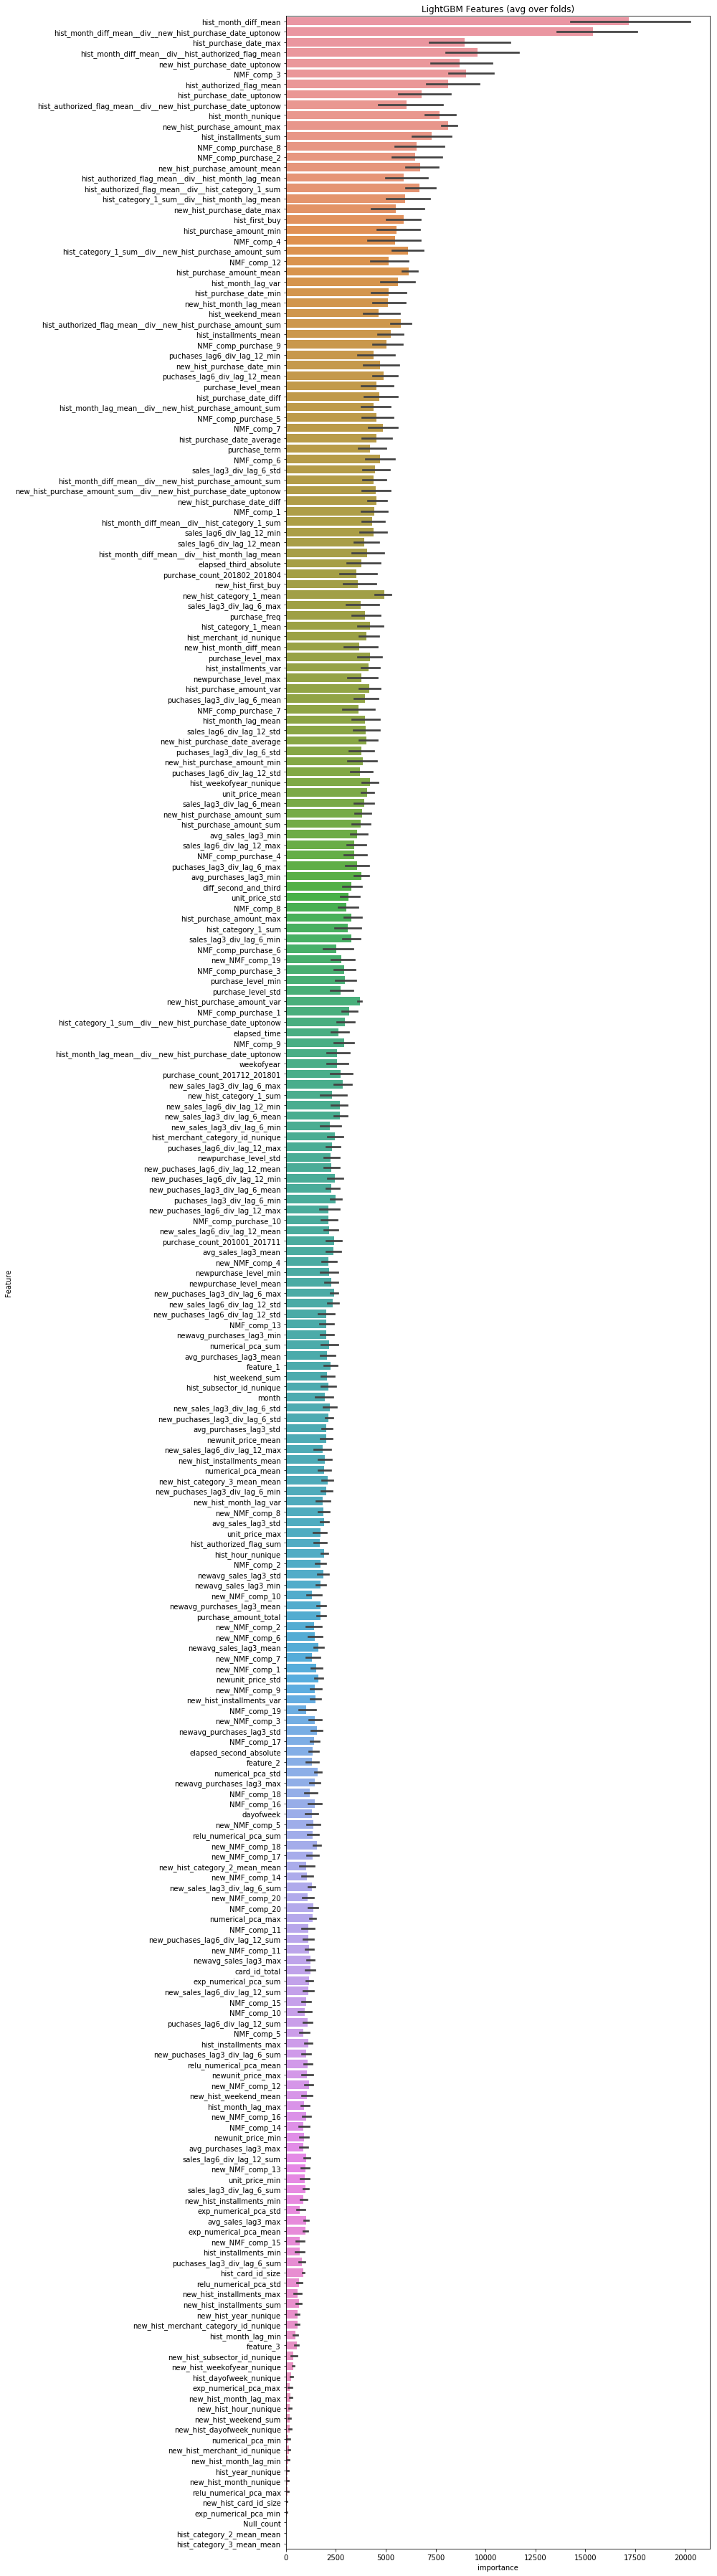

In [163]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [153]:
import optuna

In [154]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(test_x, label=test_y)

    num_round = trial.suggest_int('num_round', 1, 10000)
    param = {
        'objective': 'regression', 
        'metric': 'rmse',
        'verbosity': -1,
        'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
        'bagging_seed': 11,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
        'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
    return rmse

study = optuna.create_study()
study.optimize(objective, n_trials=20)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.79507	valid_1's rmse: 3.91285
[200]	training's rmse: 3.76532	valid_1's rmse: 3.89126
[300]	training's rmse: 3.73847	valid_1's rmse: 3.87251
[400]	training's rmse: 3.71414	valid_1's rmse: 3.8565
[500]	training's rmse: 3.69193	valid_1's rmse: 3.84265
[600]	training's rmse: 3.67173	valid_1's rmse: 3.83074
[700]	training's rmse: 3.65306	valid_1's rmse: 3.82026
[800]	training's rmse: 3.63583	valid_1's rmse: 3.81113
[900]	training's rmse: 3.61965	valid_1's rmse: 3.803
[1000]	training's rmse: 3.60428	valid_1's rmse: 3.79585
[1100]	training's rmse: 3.58923	valid_1's rmse: 3.78919
[1200]	training's rmse: 3.57537	valid_1's rmse: 3.78314
[1300]	training's rmse: 3.56206	valid_1's rmse: 3.77764
[1400]	training's rmse: 3.54888	valid_1's rmse: 3.77269
[1500]	training's rmse: 3.53652	valid_1's rmse: 3.76834
[1600]	training's rmse: 3.52485	valid_1's rmse: 3.76452
[1700]	training's rmse: 3.51354	valid_1's rmse: 3.761

[I 2018-12-16 00:10:59,806] Finished a trial resulted in value: 3.7386909077339885. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.82525	valid_1's rmse: 3.93523
[200]	training's rmse: 3.82234	valid_1's rmse: 3.93229
[300]	training's rmse: 3.81947	valid_1's rmse: 3.92942
[400]	training's rmse: 3.81663	valid_1's rmse: 3.92655
[500]	training's rmse: 3.81386	valid_1's rmse: 3.92378
[600]	training's rmse: 3.81112	valid_1's rmse: 3.92102
[700]	training's rmse: 3.80843	valid_1's rmse: 3.91832
[800]	training's rmse: 3.80578	valid_1's rmse: 3.91564
[900]	training's rmse: 3.80319	valid_1's rmse: 3.91301
[1000]	training's rmse: 3.80065	valid_1's rmse: 3.91047
[1100]	training's rmse: 3.79813	valid_1's rmse: 3.90795
Did not meet early stopping. Best iteration is:
[1153]	training's rmse: 3.79682	valid_1's rmse: 3.90664


[I 2018-12-16 00:12:10,448] Finished a trial resulted in value: 3.9013824299895026. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.81597	valid_1's rmse: 3.92806
[200]	training's rmse: 3.80986	valid_1's rmse: 3.92263
[300]	training's rmse: 3.80328	valid_1's rmse: 3.9162
[400]	training's rmse: 3.7995	valid_1's rmse: 3.91279
[500]	training's rmse: 3.79348	valid_1's rmse: 3.9069
[600]	training's rmse: 3.7897	valid_1's rmse: 3.90322
[700]	training's rmse: 3.78701	valid_1's rmse: 3.90081
[800]	training's rmse: 3.78495	valid_1's rmse: 3.89884
[900]	training's rmse: 3.78108	valid_1's rmse: 3.89516
[1000]	training's rmse: 3.7785	valid_1's rmse: 3.89276
[1100]	training's rmse: 3.77524	valid_1's rmse: 3.88967
[1200]	training's rmse: 3.77343	valid_1's rmse: 3.88802
[1300]	training's rmse: 3.77056	valid_1's rmse: 3.88529
[1400]	training's rmse: 3.76676	valid_1's rmse: 3.88168
[1500]	training's rmse: 3.76466	valid_1's rmse: 3.87971
[1600]	training's rmse: 3.76339	valid_1's rmse: 3.87853
[1700]	training's rmse: 3.76209	valid_1's rmse: 3.87734

[I 2018-12-16 00:57:45,803] Finished a trial resulted in value: 3.81947837490267. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.11797	valid_1's rmse: 3.78574
[200]	training's rmse: 2.75715	valid_1's rmse: 3.83252
[300]	training's rmse: 2.47877	valid_1's rmse: 3.86381
[400]	training's rmse: 2.23944	valid_1's rmse: 3.88872
Early stopping, best iteration is:
[18]	training's rmse: 3.52239	valid_1's rmse: 3.74051


[I 2018-12-16 00:58:39,571] Finished a trial resulted in value: 3.748522443928645. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.81893	valid_1's rmse: 3.92935
[200]	training's rmse: 3.81009	valid_1's rmse: 3.92093
[300]	training's rmse: 3.80169	valid_1's rmse: 3.91302
[400]	training's rmse: 3.79359	valid_1's rmse: 3.90539
[500]	training's rmse: 3.78593	valid_1's rmse: 3.89828
[600]	training's rmse: 3.77854	valid_1's rmse: 3.89139
[700]	training's rmse: 3.77152	valid_1's rmse: 3.88493
[800]	training's rmse: 3.76479	valid_1's rmse: 3.87871
[900]	training's rmse: 3.75838	valid_1's rmse: 3.87284
[1000]	training's rmse: 3.75223	valid_1's rmse: 3.86727
[1100]	training's rmse: 3.7463	valid_1's rmse: 3.86203
[1200]	training's rmse: 3.74068	valid_1's rmse: 3.85705
[1300]	training's rmse: 3.73528	valid_1's rmse: 3.85233
[1400]	training's rmse: 3.73009	valid_1's rmse: 3.84784
[1500]	training's rmse: 3.72511	valid_1's rmse: 3.8436
[1600]	training's rmse: 3.72031	valid_1's rmse: 3.83955
[1700]	training's rmse: 3.71566	valid_1's rmse: 3.83

[I 2018-12-16 01:01:21,410] Finished a trial resulted in value: 3.818753840260984. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.82397	valid_1's rmse: 3.93396
[200]	training's rmse: 3.81984	valid_1's rmse: 3.92984
[300]	training's rmse: 3.81581	valid_1's rmse: 3.92581
[400]	training's rmse: 3.81187	valid_1's rmse: 3.92187
[500]	training's rmse: 3.80807	valid_1's rmse: 3.91811
[600]	training's rmse: 3.80435	valid_1's rmse: 3.91443
[700]	training's rmse: 3.80071	valid_1's rmse: 3.91084
[800]	training's rmse: 3.79714	valid_1's rmse: 3.90732
[900]	training's rmse: 3.79372	valid_1's rmse: 3.90394
[1000]	training's rmse: 3.79034	valid_1's rmse: 3.90062
[1100]	training's rmse: 3.78706	valid_1's rmse: 3.89738
[1200]	training's rmse: 3.78385	valid_1's rmse: 3.89423
[1300]	training's rmse: 3.78077	valid_1's rmse: 3.8912
[1400]	training's rmse: 3.77775	valid_1's rmse: 3.88823
[1500]	training's rmse: 3.77483	valid_1's rmse: 3.88537
[1600]	training's rmse: 3.77195	valid_1's rmse: 3.88253
[1700]	training's rmse: 3.76906	valid_1's rmse: 3.8

[I 2018-12-16 01:14:59,934] Finished a trial resulted in value: 3.7802441062107612. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.79544	valid_1's rmse: 3.90559
[200]	training's rmse: 3.76921	valid_1's rmse: 3.87965
[300]	training's rmse: 3.74753	valid_1's rmse: 3.8582
[400]	training's rmse: 3.72948	valid_1's rmse: 3.84049
[500]	training's rmse: 3.71462	valid_1's rmse: 3.82619
[600]	training's rmse: 3.70187	valid_1's rmse: 3.81421
[700]	training's rmse: 3.69085	valid_1's rmse: 3.80427
[800]	training's rmse: 3.68083	valid_1's rmse: 3.79555
[900]	training's rmse: 3.67203	valid_1's rmse: 3.78809
[1000]	training's rmse: 3.66423	valid_1's rmse: 3.78165
[1100]	training's rmse: 3.65729	valid_1's rmse: 3.77617
[1200]	training's rmse: 3.65117	valid_1's rmse: 3.77158
[1300]	training's rmse: 3.64563	valid_1's rmse: 3.7676
[1400]	training's rmse: 3.64062	valid_1's rmse: 3.76431
[1500]	training's rmse: 3.6359	valid_1's rmse: 3.76128
[1600]	training's rmse: 3.63163	valid_1's rmse: 3.75874
[1700]	training's rmse: 3.62754	valid_1's rmse: 3.756

[I 2018-12-16 01:25:22,108] Finished a trial resulted in value: 3.7396535976282155. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.29445	valid_1's rmse: 3.74276
[200]	training's rmse: 3.06861	valid_1's rmse: 3.75593
[300]	training's rmse: 2.87389	valid_1's rmse: 3.77426
[400]	training's rmse: 2.71656	valid_1's rmse: 3.78464
Early stopping, best iteration is:
[46]	training's rmse: 3.44252	valid_1's rmse: 3.73455


[I 2018-12-16 01:26:11,391] Finished a trial resulted in value: 3.743674888267313. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.82826	valid_1's rmse: 3.93991
[200]	training's rmse: 3.8278	valid_1's rmse: 3.93983
[300]	training's rmse: 3.82561	valid_1's rmse: 3.93764
[400]	training's rmse: 3.8247	valid_1's rmse: 3.93672
Early stopping, best iteration is:
[92]	training's rmse: 3.82345	valid_1's rmse: 3.93346


[I 2018-12-16 01:26:56,937] Finished a trial resulted in value: 3.960680197936956. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.50267	valid_1's rmse: 3.73495
[200]	training's rmse: 3.42286	valid_1's rmse: 3.73914
[300]	training's rmse: 3.34741	valid_1's rmse: 3.74421
[400]	training's rmse: 3.28016	valid_1's rmse: 3.75113
Did not meet early stopping. Best iteration is:
[429]	training's rmse: 3.26072	valid_1's rmse: 3.75236


[I 2018-12-16 01:27:23,013] Finished a trial resulted in value: 3.763533138528541. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.68442	valid_1's rmse: 3.84191
[200]	training's rmse: 3.59105	valid_1's rmse: 3.79606
[300]	training's rmse: 3.51569	valid_1's rmse: 3.76866
[400]	training's rmse: 3.45416	valid_1's rmse: 3.75294
[500]	training's rmse: 3.40296	valid_1's rmse: 3.74431
[600]	training's rmse: 10.4643	valid_1's rmse: 10.6377
[700]	training's rmse: 7.39562	valid_1's rmse: 7.61731
[800]	training's rmse: 5.50081	valid_1's rmse: 5.79042
[900]	training's rmse: 4.39935	valid_1's rmse: 4.76258
Early stopping, best iteration is:
[514]	training's rmse: 3.39663	valid_1's rmse: 3.74338


[I 2018-12-16 01:29:44,319] Finished a trial resulted in value: 3.7535741866854133. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.71453	valid_1's rmse: 3.8787
[200]	training's rmse: 3.62542	valid_1's rmse: 3.83787
[300]	training's rmse: 3.55338	valid_1's rmse: 3.81115
[400]	training's rmse: 3.49215	valid_1's rmse: 3.79211
[500]	training's rmse: 3.43889	valid_1's rmse: 3.77903
[600]	training's rmse: 3.39221	valid_1's rmse: 3.77032
[700]	training's rmse: 3.35014	valid_1's rmse: 3.76329
[800]	training's rmse: 3.31318	valid_1's rmse: 3.75668
[900]	training's rmse: 3.27854	valid_1's rmse: 3.7525
[1000]	training's rmse: 3.24673	valid_1's rmse: 3.74929
[1100]	training's rmse: 3.21811	valid_1's rmse: 3.74676
[1200]	training's rmse: 3.19186	valid_1's rmse: 3.74486
[1300]	training's rmse: 3.16636	valid_1's rmse: 3.74314
[1400]	training's rmse: 3.14268	valid_1's rmse: 3.74143
[1500]	training's rmse: 3.12028	valid_1's rmse: 3.74044
[1600]	training's rmse: 3.09803	valid_1's rmse: 3.73916
[1700]	training's rmse: 3.07735	valid_1's rmse: 3.73

[I 2018-12-16 01:37:26,482] Finished a trial resulted in value: 3.74349441522068. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.82424	valid_1's rmse: 3.94205
[200]	training's rmse: 3.82763	valid_1's rmse: 3.9457
[300]	training's rmse: 3.82795	valid_1's rmse: 3.94606
[400]	training's rmse: 3.82837	valid_1's rmse: 3.94655
Early stopping, best iteration is:
[51]	training's rmse: 3.81398	valid_1's rmse: 3.93013


[I 2018-12-16 01:39:31,601] Finished a trial resulted in value: 3.960680197936956. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.71999	valid_1's rmse: 3.85703
[200]	training's rmse: 3.64769	valid_1's rmse: 3.81171
[300]	training's rmse: 3.59246	valid_1's rmse: 3.78445
[400]	training's rmse: 3.5469	valid_1's rmse: 3.76623
[500]	training's rmse: 3.5089	valid_1's rmse: 3.75465
[600]	training's rmse: 3.47601	valid_1's rmse: 3.7473
[700]	training's rmse: 3.44665	valid_1's rmse: 3.74251
[800]	training's rmse: 3.42096	valid_1's rmse: 3.7398
[900]	training's rmse: 3.39704	valid_1's rmse: 3.73716
[1000]	training's rmse: 3.37536	valid_1's rmse: 3.73525
[1100]	training's rmse: 3.35527	valid_1's rmse: 3.73402
[1200]	training's rmse: 3.33636	valid_1's rmse: 3.73321
[1300]	training's rmse: 3.3175	valid_1's rmse: 3.73271
[1400]	training's rmse: 3.3002	valid_1's rmse: 3.73192
[1500]	training's rmse: 3.28337	valid_1's rmse: 3.73151
[1600]	training's rmse: 3.26722	valid_1's rmse: 3.73115
[1700]	training's rmse: 3.25141	valid_1's rmse: 3.73074


[I 2018-12-16 01:45:32,130] Finished a trial resulted in value: 3.740357501950261. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74231	valid_1's rmse: 3.87944
[200]	training's rmse: 3.6756	valid_1's rmse: 3.83943
[300]	training's rmse: 3.6219	valid_1's rmse: 3.81242
[400]	training's rmse: 3.57613	valid_1's rmse: 3.79296
[500]	training's rmse: 16.6695	valid_1's rmse: 16.5209
[600]	training's rmse: 12.8763	valid_1's rmse: 12.8114
[700]	training's rmse: 10.5497	valid_1's rmse: 10.5558
[800]	training's rmse: 8.70964	valid_1's rmse: 8.78883
Early stopping, best iteration is:
[473]	training's rmse: 3.54563	valid_1's rmse: 3.78127


[I 2018-12-16 01:47:27,096] Finished a trial resulted in value: 3.7933053426399885. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.60206	valid_1's rmse: 3.83314
[200]	training's rmse: 3.45655	valid_1's rmse: 3.78938
[300]	training's rmse: 3.35014	valid_1's rmse: 3.77057
[400]	training's rmse: 3.26634	valid_1's rmse: 3.7575
[500]	training's rmse: 3.19478	valid_1's rmse: 3.75221
[600]	training's rmse: 3.13607	valid_1's rmse: 3.74814
[700]	training's rmse: 3.08326	valid_1's rmse: 3.74538
[800]	training's rmse: 3.03579	valid_1's rmse: 3.74287
[900]	training's rmse: 2.9901	valid_1's rmse: 3.7418
[1000]	training's rmse: 2.94897	valid_1's rmse: 3.7402
[1100]	training's rmse: 2.91014	valid_1's rmse: 3.73945
[1200]	training's rmse: 2.87413	valid_1's rmse: 3.73892
[1300]	training's rmse: 2.84086	valid_1's rmse: 3.7381
[1400]	training's rmse: 2.81087	valid_1's rmse: 3.73782
[1500]	training's rmse: 2.78238	valid_1's rmse: 3.73745
[1600]	training's rmse: 2.75495	valid_1's rmse: 3.7373
[1700]	training's rmse: 2.72876	valid_1's rmse: 3.73713


[I 2018-12-16 01:52:24,303] Finished a trial resulted in value: 3.7448530408014644. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.83932	valid_1's rmse: 3.95391
[200]	training's rmse: 3.84125	valid_1's rmse: 3.95592
[300]	training's rmse: 3.84153	valid_1's rmse: 3.95623
[400]	training's rmse: 3.8417	valid_1's rmse: 3.95644
Early stopping, best iteration is:
[8]	training's rmse: 3.82471	valid_1's rmse: 3.936


[I 2018-12-16 01:54:23,387] Finished a trial resulted in value: 3.960680197936956. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.82565	valid_1's rmse: 3.93557
[200]	training's rmse: 3.82311	valid_1's rmse: 3.93296
[300]	training's rmse: 3.82062	valid_1's rmse: 3.9304
[400]	training's rmse: 3.81814	valid_1's rmse: 3.92784
[500]	training's rmse: 3.81573	valid_1's rmse: 3.92536
[600]	training's rmse: 3.81335	valid_1's rmse: 3.92289
[700]	training's rmse: 3.811	valid_1's rmse: 3.92047
[800]	training's rmse: 3.80868	valid_1's rmse: 3.91809
[900]	training's rmse: 3.80643	valid_1's rmse: 3.91578
[1000]	training's rmse: 3.80419	valid_1's rmse: 3.91349
[1100]	training's rmse: 3.80198	valid_1's rmse: 3.91122
[1200]	training's rmse: 3.7998	valid_1's rmse: 3.909
[1300]	training's rmse: 3.7977	valid_1's rmse: 3.90686
[1400]	training's rmse: 3.79566	valid_1's rmse: 3.90477
[1500]	training's rmse: 3.79367	valid_1's rmse: 3.90274
[1600]	training's rmse: 3.79167	valid_1's rmse: 3.9007
[1700]	training's rmse: 3.78971	valid_1's rmse: 3.89869
[1

[I 2018-12-16 02:01:37,804] Finished a trial resulted in value: 3.8153025902660462. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.81491	valid_1's rmse: 3.92431
[200]	training's rmse: 3.80286	valid_1's rmse: 3.91181
[300]	training's rmse: 3.79197	valid_1's rmse: 3.90052
[400]	training's rmse: 3.78197	valid_1's rmse: 3.89011
[500]	training's rmse: 3.77289	valid_1's rmse: 3.88076
[600]	training's rmse: 3.76438	valid_1's rmse: 3.87202
[700]	training's rmse: 3.7564	valid_1's rmse: 3.86394
[800]	training's rmse: 3.74894	valid_1's rmse: 3.85637
[900]	training's rmse: 3.74205	valid_1's rmse: 3.8494
[1000]	training's rmse: 3.7356	valid_1's rmse: 3.84287
[1100]	training's rmse: 3.72964	valid_1's rmse: 3.83688
[1200]	training's rmse: 3.72404	valid_1's rmse: 3.83129
[1300]	training's rmse: 3.71891	valid_1's rmse: 3.82616
[1400]	training's rmse: 3.71409	valid_1's rmse: 3.82137
[1500]	training's rmse: 3.70969	valid_1's rmse: 3.81701
[1600]	training's rmse: 3.70556	valid_1's rmse: 3.81293
[1700]	training's rmse: 3.70166	valid_1's rmse: 3.809

[I 2018-12-16 02:07:57,960] Finished a trial resulted in value: 3.756294614810762. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.75926	valid_1's rmse: 3.87054
[200]	training's rmse: 3.71591	valid_1's rmse: 3.8285
[300]	training's rmse: 3.68697	valid_1's rmse: 3.80183
[400]	training's rmse: 3.66507	valid_1's rmse: 3.78406
[500]	training's rmse: 3.64871	valid_1's rmse: 3.77154
[600]	training's rmse: 3.63546	valid_1's rmse: 3.76316
[700]	training's rmse: 3.62466	valid_1's rmse: 3.75697
[800]	training's rmse: 3.61527	valid_1's rmse: 3.75192
[900]	training's rmse: 3.60704	valid_1's rmse: 3.74896
[1000]	training's rmse: 3.59982	valid_1's rmse: 3.74632
[1100]	training's rmse: 3.59298	valid_1's rmse: 3.74413
[1200]	training's rmse: 3.58689	valid_1's rmse: 3.74242
[1300]	training's rmse: 3.581	valid_1's rmse: 3.74101
[1400]	training's rmse: 3.57533	valid_1's rmse: 3.73989
[1500]	training's rmse: 3.56996	valid_1's rmse: 3.73912
[1600]	training's rmse: 3.56474	valid_1's rmse: 3.73817
[1700]	training's rmse: 3.55974	valid_1's rmse: 3.737

[I 2018-12-16 02:14:57,584] Finished a trial resulted in value: 3.7396450700381885. Current best value is 3.7386909077339885 with parameters: {'num_round': 8741, 'feature_fraction': 0.9409995428090514, 'bagging_fraction': 0.8337924713497857, 'boosting': 'goss', 'num_leaves': 100, 'learning_rate': 0.0007946754978223636, 'min_child_samples': 38, 'min_data_in_leaf': 86, 'lambda_l1': 0.01564804574114976, 'top_rate': 0.8376429100294606, 'other_rate': 0.025061425578869534}.


Number of finished trials: 20
Best trial:
  Value: 3.7386909077339885
  Params: 
    num_round: 8741
    feature_fraction: 0.9409995428090514
    bagging_fraction: 0.8337924713497857
    boosting: goss
    num_leaves: 100
    learning_rate: 0.0007946754978223636
    min_child_samples: 38
    min_data_in_leaf: 86
    lambda_l1: 0.01564804574114976
    top_rate: 0.8376429100294606
    other_rate: 0.025061425578869534


In [162]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../output/submission_model20181215.csv", index=False)